## Постановка задачи

Реализовать пайплайн:

1.      Найдите в открытых источниках исторические данные о покупках смартфонов, на kaggle например. Спрофилируйте пользователей,

2.      Найдите в открытых источниках список товаров. Как вариант - спарсите наш сайт. Кластеризуйте товары,

3.      Реализовать прогнозную модель – какой пользователь, когда и какой товар (не только смартфон видимо) хотел бы приобрести,

4.      Предложите маркетинговый инструмент – куда на вход подались бы данные прогноза, а на выход получилась бы таргетированная реклама гугл. Например https://financesonline.com/top-10-free-marketing-automation-software/. 

В качестве датасета взяты данные с соревнования Instacart Market Basket Analysis: https://www.kaggle.com/c/instacart-market-basket-analysis/data 

Набор данных для этого конкурса представляет собой реляционный набор файлов, описывающих заказы клиентов во времени. Цель конкурса - предсказать, какие продукты будут заказаны. Набор данных является анонимным и содержит выборку из более чем 3 миллионов продуктовых заказов от более чем 200 000 пользователей Instacart. Для каждого пользователя мы предоставляем от 4 до 100 их заказов с последовательностью продуктов, приобретенных в каждом заказе. Мы также предоставляем неделю и час дня, когда был размещен заказ, и относительную меру времени между заказами.

Более подробное описание данных по ссылке.

## Cегменты клиентов

Попробуем сегментировать и профилировать клиентов

### PCA и Kmeans класстеризация

In [2]:
import numpy as np 
import pandas as pd 

from subprocess import check_output

In [3]:
orders = pd.read_csv('data/orders.csv')

In [4]:
prior = pd.read_csv('data/order_products__prior.csv')

In [5]:
train = pd.read_csv('data/order_products__train.csv')

Из-за количества строк нужно уменьшить набор предыдущих данных для примера

In [6]:
prior = prior[0:300000]
order_prior = pd.merge(prior,orders,on=['order_id','order_id'])
order_prior = order_prior.sort_values(by=['user_id','order_id'])
products = pd.read_csv('data/products.csv')
aisles = pd.read_csv('data/aisles.csv')
_mt = pd.merge(prior,products, on = ['product_id','product_id'])
_mt = pd.merge(_mt,orders,on=['order_id','order_id'])
mt = pd.merge(_mt,aisles,on=['aisle_id','aisle_id'])

In [7]:
mt['product_name'].value_counts()[0:10]

Banana                    4432
Bag of Organic Bananas    3563
Organic Strawberries      2370
Organic Baby Spinach      2242
Organic Hass Avocado      1985
Organic Avocado           1626
Large Lemon               1380
Strawberries              1343
Organic Raspberries       1293
Limes                     1270
Name: product_name, dtype: int64

In [8]:
cust_prod = pd.crosstab(mt['user_id'], mt['aisle'])

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(cust_prod)
pca_samples = pca.transform(cust_prod)

In [10]:
ps = pd.DataFrame(pca_samples)

In [12]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
tocluster = pd.DataFrame(ps[[4,1]])
print (tocluster.shape)
print (tocluster.head())

(25831, 2)
          4         1
0 -0.587400  1.005868
1  0.046019 -0.487659
2 -0.648880  1.284089
3 -0.353568  1.250081
4  0.006117 -0.422148


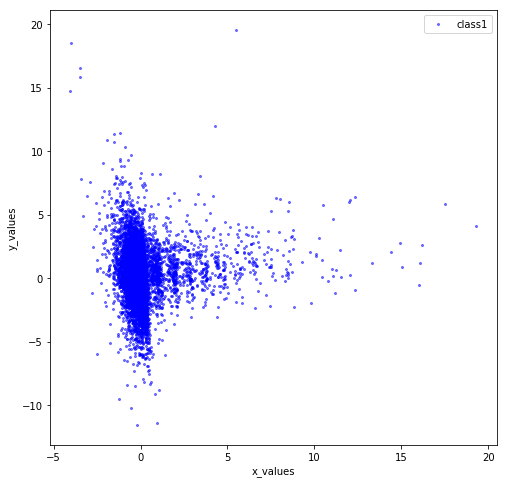

In [13]:
fig = plt.figure(figsize=(8,8))
plt.plot(tocluster[4], tocluster[1], 'o', markersize=2, color='blue', alpha=0.5, label='class1')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


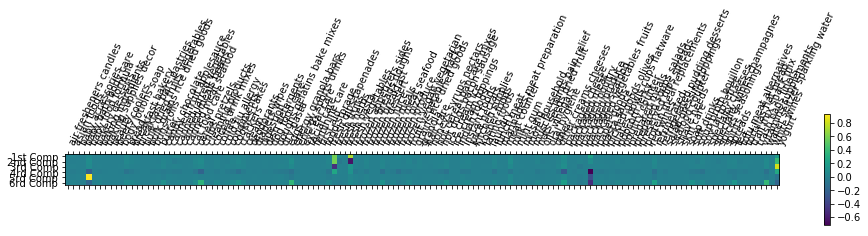

In [35]:
plt.matshow(pca.components_,cmap='viridis')
plt.yticks([0,1,2,3,4,5],['1st Comp','2nd Comp','3rd Comp','4rd Comp','5rd Comp','6rd Comp'],fontsize=10)
plt.colorbar()
plt.xticks(range(len(cust_prod.columns.values)),cust_prod.columns.values,rotation=65,ha='left')
plt.tight_layout()
plt.show()

У нас 6 компонент. Можем видеть, что практически во всех компонентах коэффициенты признаков имеют одинаковые знаки. Это означает, что существует общая корреляция между всеми признаками. Высоким значениям одного признака будут соответсовать высокие значения остальных признаков.

Для определения количества кластеров отрисовываем средние евклидовы расстояния до каждого элемента от центроида кластера, используя метод Elbow.

In [39]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [43]:
from scipy.spatial.distance import cdist
clusters=range(1,15)
meandist=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(cust_prod)
    meandist.append(sum(np.min(cdist(cust_prod, model.cluster_centers_, 'euclidean'), axis=1)) 
    / cust_prod.shape[0])

Text(0.5,1,'Выбор k методом Elbow Method')

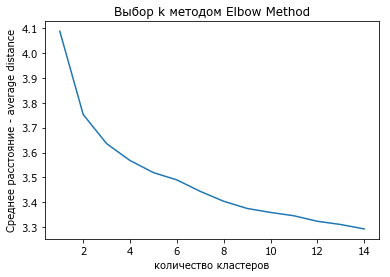

In [44]:
import matplotlib
matplotlib.rc('font', family='Verdana')

plt.plot(clusters, meandist)
plt.xlabel(u'количество кластеров')
plt.ylabel(u'Среднее расстояние - average distance')
plt.title(u'Выбор k методом Elbow Method')

Таким образом, предположительно в данных можно выделить 4-6 кластеров

Далее для кластеризации данных будем использовать алгоритм KMeans.

In [52]:
clusterer = KMeans(n_clusters=4,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
print(centers)

[[-0.00793073 -2.39936986]
 [-0.04626499 -0.15452148]
 [-0.24952659  2.06102734]
 [ 5.55594561  1.45663525]]


['purple', 'blue', 'purple', 'purple', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue']


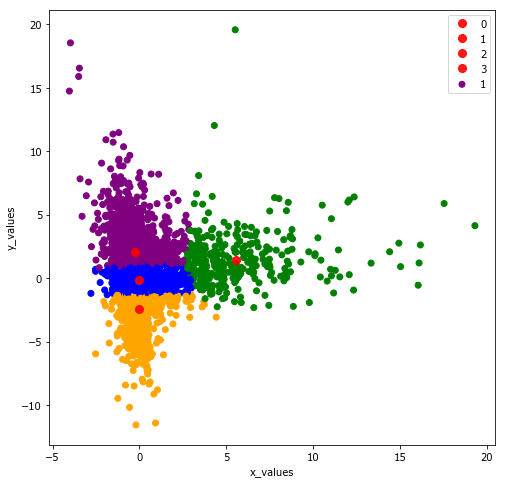

In [54]:
import matplotlib
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','purple','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[4],tocluster[1],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

Мы нашли возможную кластеризацию для наших клиентов. Давайте проверим, сможем ли мы найти какой-то интересный паттерн по ним.

In [55]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

clust_prod.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
13,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
23,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,4,2
27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,4,2
36,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
66,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
67,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
70,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


(25831, 135)


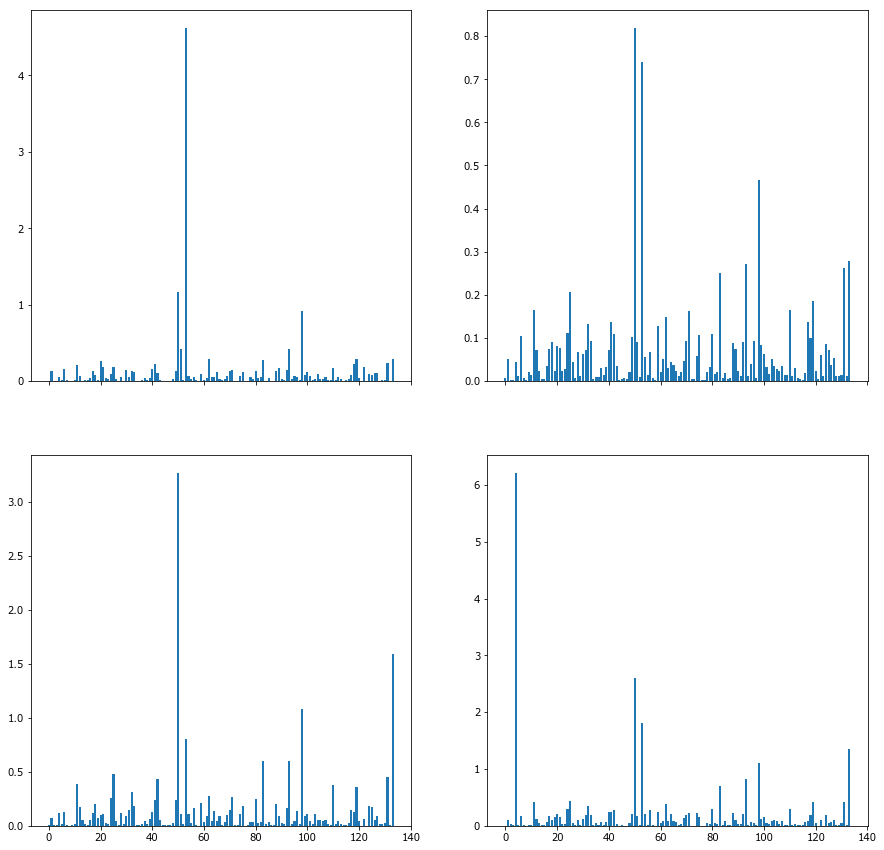

In [56]:
print (clust_prod.shape)
f,arr = plt.subplots(2,2,sharex=True,figsize=(15,15))

c1_count = len(clust_prod[clust_prod['cluster']==0])

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
arr[0,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c0)
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
arr[0,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c1)
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()
arr[1,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c2)
c3 = clust_prod[clust_prod['cluster']==3].drop('cluster',axis=1).mean()
arr[1,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c3)
plt.show()

Давайте посмотрим, какие товары из топ-10 покупают люди каждого кластера. Мы будем полагаться сначала на абсолютные данные, а затем на процентную долю среди 8 лучших продуктов для каждого кластера.

In [57]:
c0.sort_values(ascending=False)[0:10]

aisle
fresh vegetables              4.620428
fresh fruits                  1.163216
packaged vegetables fruits    0.922015
packaged cheese               0.423395
fresh herbs                   0.421670
soy lactosefree               0.288475
yogurt                        0.287095
frozen produce                0.282264
milk                          0.279848
canned jarred vegetables      0.261560
dtype: float64

In [58]:
c1.sort_values(ascending=False)[0:10]

aisle
fresh fruits                     0.818765
fresh vegetables                 0.739032
packaged vegetables fruits       0.465411
yogurt                           0.278152
packaged cheese                  0.271190
water seltzer sparkling water    0.262847
milk                             0.249641
chips pretzels                   0.205824
soy lactosefree                  0.185766
refrigerated                     0.164825
dtype: float64

In [59]:
c2.sort_values(ascending=False)[0:10]

aisle
fresh fruits                     3.268080
yogurt                           1.592411
packaged vegetables fruits       1.078795
fresh vegetables                 0.802455
packaged cheese                  0.603571
milk                             0.597768
chips pretzels                   0.481696
water seltzer sparkling water    0.452009
energy granola bars              0.432812
bread                            0.383705
dtype: float64

In [60]:
c3.sort_values(ascending=False)[0:10]

aisle
baby food formula                6.214085
fresh fruits                     2.605634
fresh vegetables                 1.814085
yogurt                           1.343662
packaged vegetables fruits       1.101408
packaged cheese                  0.828169
milk                             0.695775
chips pretzels                   0.430986
water seltzer sparkling water    0.419718
soy lactosefree                  0.419718
dtype: float64

Первый анализ кластеров подтверждает первоначальную гипотезу о том, что:

     свежие фрукты
     свежие овощи
     упакованные овощи фрукты
     йогурт
     упакованный сыр
     молоко
     вода сельтерская газированная вода
     чипсы крендели

являются продуктами, которые обычно покупаются большинством покупателей.

Здесь мы можем проверить, отличаются ли кластеры по количеству и пропорциям в отношении этих товаров или если кластер характеризуется некоторыми товарами, не включенными в этот список. Например, мы уже видим, что кластер 3 характеризуется продуктом «Формула детского питания», что является существенным отличием по сравнению с другими кластерами.

In [61]:
from IPython.display import display, HTML
cluster_means = [[c0['fresh fruits'],c0['fresh vegetables'],c0['packaged vegetables fruits'], c0['yogurt'], c0['packaged cheese'], c0['milk'],c0['water seltzer sparkling water'],c0['chips pretzels']],
                 [c1['fresh fruits'],c1['fresh vegetables'],c1['packaged vegetables fruits'], c1['yogurt'], c1['packaged cheese'], c1['milk'],c1['water seltzer sparkling water'],c1['chips pretzels']],
                 [c2['fresh fruits'],c2['fresh vegetables'],c2['packaged vegetables fruits'], c2['yogurt'], c2['packaged cheese'], c2['milk'],c2['water seltzer sparkling water'],c2['chips pretzels']],
                 [c3['fresh fruits'],c3['fresh vegetables'],c3['packaged vegetables fruits'], c3['yogurt'], c3['packaged cheese'], c3['milk'],c3['water seltzer sparkling water'],c3['chips pretzels']]]
cluster_means = pd.DataFrame(cluster_means, columns = ['fresh fruits','fresh vegetables','packaged vegetables fruits','yogurt','packaged cheese','milk','water seltzer sparkling water','chips pretzels'])
HTML(cluster_means.to_html())

,fresh fruits,fresh vegetables,packaged vegetables fruits,yogurt,packaged cheese,milk,water seltzer sparkling water,chips pretzels
0,1.163216,4.620428,0.922015,0.287095,0.423395,0.279848,0.242581,0.188061
1,0.818765,0.739032,0.465411,0.278152,0.271190,0.249641,0.262847,0.205824
2,3.268080,0.802455,1.078795,1.592411,0.603571,0.597768,0.452009,0.481696
3,2.605634,1.814085,1.101408,1.343662,0.828169,0.695775,0.419718,0.430986


В следующей таблице представлен процент этих товаров по отношению к другим 8 в каждом кластере. Легко найти интересные различия между кластерами.

Кажется, что люди кластера 1 покупают больше свежих овощей, чем другие кластеры. Как показывают абсолютные данные, кластер 1 также является кластером, включающим тех клиентов, которые покупают гораздо больше товаров, чем любые другие.

Люди из группы 2 покупают больше йогурта, чем люди из других групп.

Абсолютные данные показывают, что люди из кластера 3 покупают много «формулы детского питания», которая даже не включена в топ-8 продуктов, но в основном характеризует этот кластер.

In [62]:
cluster_perc = cluster_means.iloc[:, :].apply(lambda x: (x / x.sum())*100,axis=1)
HTML(cluster_perc.to_html())

,fresh fruits,fresh vegetables,packaged vegetables fruits,yogurt,packaged cheese,milk,water seltzer sparkling water,chips pretzels
0,14.313617,56.855335,11.345590,3.532759,5.209970,3.443591,2.985011,2.314127
1,24.879949,22.457101,14.142517,8.452265,8.240707,7.585883,7.987172,6.254407
2,36.816033,9.039932,12.152987,17.939046,6.799437,6.734058,5.092034,5.426474
3,28.201220,19.634146,11.920732,14.542683,8.963415,7.530488,4.542683,4.664634


Я думаю, что еще одна интересная информация, которую я могу найти, - это десятые и пятнадцатые наиболее покупаемые продукты для каждого кластера, которые не будут включать общие продукты (например, овощи, фрукты, вода и т. Д.), Купленные кем-либо.

In [63]:
c0.sort_values(ascending=False)[10:15]

aisle
water seltzer sparkling water    0.242581
eggs                             0.226363
soup broth bouillon              0.226363
bread                            0.213251
canned meals beans               0.188751
dtype: float64

In [64]:
c1.sort_values(ascending=False)[10:15]

aisle
bread             0.164272
ice cream ice     0.163499
frozen produce    0.149685
eggs              0.137308
soft drinks       0.136534
dtype: float64

In [65]:
c2.sort_values(ascending=False)[10:15]

aisle
refrigerated       0.381696
soy lactosefree    0.361161
crackers           0.308705
frozen produce     0.277679
ice cream ice      0.266295
dtype: float64

In [66]:
c3.sort_values(ascending=False)[10:15]

aisle
bread             0.414085
frozen produce    0.388732
crackers          0.352113
cereal            0.304225
refrigerated      0.301408
dtype: float64

Как вы можете заметить, принимая во внимание больше продуктов, кластеры начинают существенно различаться.

Таким образом мы выявили общие паттерены для клиентов.